In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_dataset(data_rootdir, dirname, group):
    '''
    该函数实现将训练数据或测试数据文件列表堆叠为三维数组
    '''
    filename_list = []
    filepath_list = []
    X = []
    
    # os.walk() 方法是一个简单易用的文件、目录遍历器，可以高效的处理文件、目录。
    for rootdir, dirnames, filenames in os.walk(data_rootdir + dirname):
        for filename in filenames:
            filename_list.append(filename)
            filepath_list.append(os.path.join(rootdir, filename))
        #print(filename_list)
        #print(filepath_list)
    
    # 遍历根目录下的文件，并读取为DataFrame格式；
    for filepath in filepath_list:
        X.append(load_file(filepath))
    
    X = np.dstack(X) # dstack沿第三个维度叠加，两个二维数组叠加后，前两个维度尺寸不变，第三个维度增加；
    y = load_file(data_rootdir+'/y_'+group+'.txt')
    print('{}_X.shape:{},{}_y.shape:{}\n'.format(group,X.shape,group,y.shape))
    return X, y

train_rootdir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/'
test_rootdir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/'
data_dirname = '/Inertial Signals/'
trainX, trainy = load_dataset(train_rootdir, data_dirname, 'train')
testX, testy = load_dataset(test_rootdir, data_dirname, 'test')

train_X.shape:(7352, 128, 9),train_y.shape:(7352, 1)

test_X.shape:(2947, 128, 9),test_y.shape:(2947, 1)



In [3]:
def class_distribution(data):
    '''
    该函数实现各分类数据的数量和百分比统计
    '''
    df = pd.DataFrame(data) # 转化为DataFrame格式
    counts = df.groupby(0).size() # axis=0沿行分组;size()方法统计每个组的大小
    print(counts)
    counts = counts.values
    print(counts)
    
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f%%' % (i+1, counts[i], percent))

print('Train Dataset Class Distribution')
class_distribution(trainy)
        
print('Test Dataset Class Distribution')
class_distribution(testy)

print('Total Class Distribution')
combined = np.vstack((trainy, testy))
class_distribution(combined)

Train Dataset Class Distribution
0
1    1226
2    1073
3     986
4    1286
5    1374
6    1407
dtype: int64
[1226 1073  986 1286 1374 1407]
Class=1, total=1226, percentage=16.676%
Class=2, total=1073, percentage=14.595%
Class=3, total=986, percentage=13.411%
Class=4, total=1286, percentage=17.492%
Class=5, total=1374, percentage=18.689%
Class=6, total=1407, percentage=19.138%
Test Dataset Class Distribution
0
1    496
2    471
3    420
4    491
5    532
6    537
dtype: int64
[496 471 420 491 532 537]
Class=1, total=496, percentage=16.831%
Class=2, total=471, percentage=15.982%
Class=3, total=420, percentage=14.252%
Class=4, total=491, percentage=16.661%
Class=5, total=532, percentage=18.052%
Class=6, total=537, percentage=18.222%
Total Class Distribution
0
1    1722
2    1544
3    1406
4    1777
5    1906
6    1944
dtype: int64
[1722 1544 1406 1777 1906 1944]
Class=1, total=1722, percentage=16.720%
Class=2, total=1544, percentage=14.992%
Class=3, total=1406, percentage=13.652%
Class=4,

In [5]:
sub_map = load_file('D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map) # 找到训练集中包含哪些志愿者（返回唯一索引列表）的数据（数据集由30位志愿者收集）
print('sub_map.shape:{}\ntrain_subjects:{}'.format(sub_map.shape,train_subjects))

sub_map.shape:(7352, 1)
train_subjects:[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [9]:
def get_sub_map(sub_filepath):
    '''
    该函数实现获取训练集或测试集中包含志愿者编号的唯一索引列表
    sub_filepath:subject_train.txt/subject_test.txt文件路径;
    filename:'train'/'test';
    '''
    sub_map = load_file('D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/subject_train.txt')
    subjects_list = np.unique(sub_map) # 找到训练集中包含哪些志愿者（返回唯一索引列表）的数据（数据集由30位志愿者收集）
    return sub_map, subjects_list

In [10]:
def data_for_subject(X, y, sub_map, sub_id):
    '''
    该函数实现根据志愿者编号来从数据X和标签y中截取相应的行数据
    '''
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    return X[ix, :, :], y[ix]

In [11]:
def to_series(windows):
    '''
    该函数实现将窗口序列数据转换为列表
    '''
    series = list()
    
    for window in windows:
        # 消除重叠窗口部分
        half = int(len(window) / 2) - 1 # 窗口一半的宽度；原数据重叠率为50%
        # 切片截取每一行的后半部分数据，正好避开重叠部分（上一行的后半部分和下一行的前半部分是重叠的）
        for value in window[-half:]:    
            series.append(value)
    return series

In [13]:
subject_train_path = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/subject_train.txt'
train_sub_map, train_subjects = get_sub_map(subject_train_path)
train_sub_id = train_subjects[0] # 志愿者列表中编号为1的志愿者
train_subX, train_suby = data_for_subject(trainX, trainy, train_sub_map, train_sub_id)
print('train_subX.shape:{}\ntrain_suby.shape:{}'.format(train_subX.shape, train_suby.shape))

train_subX.shape:(347, 128, 9)
train_suby.shape:(347, 1)


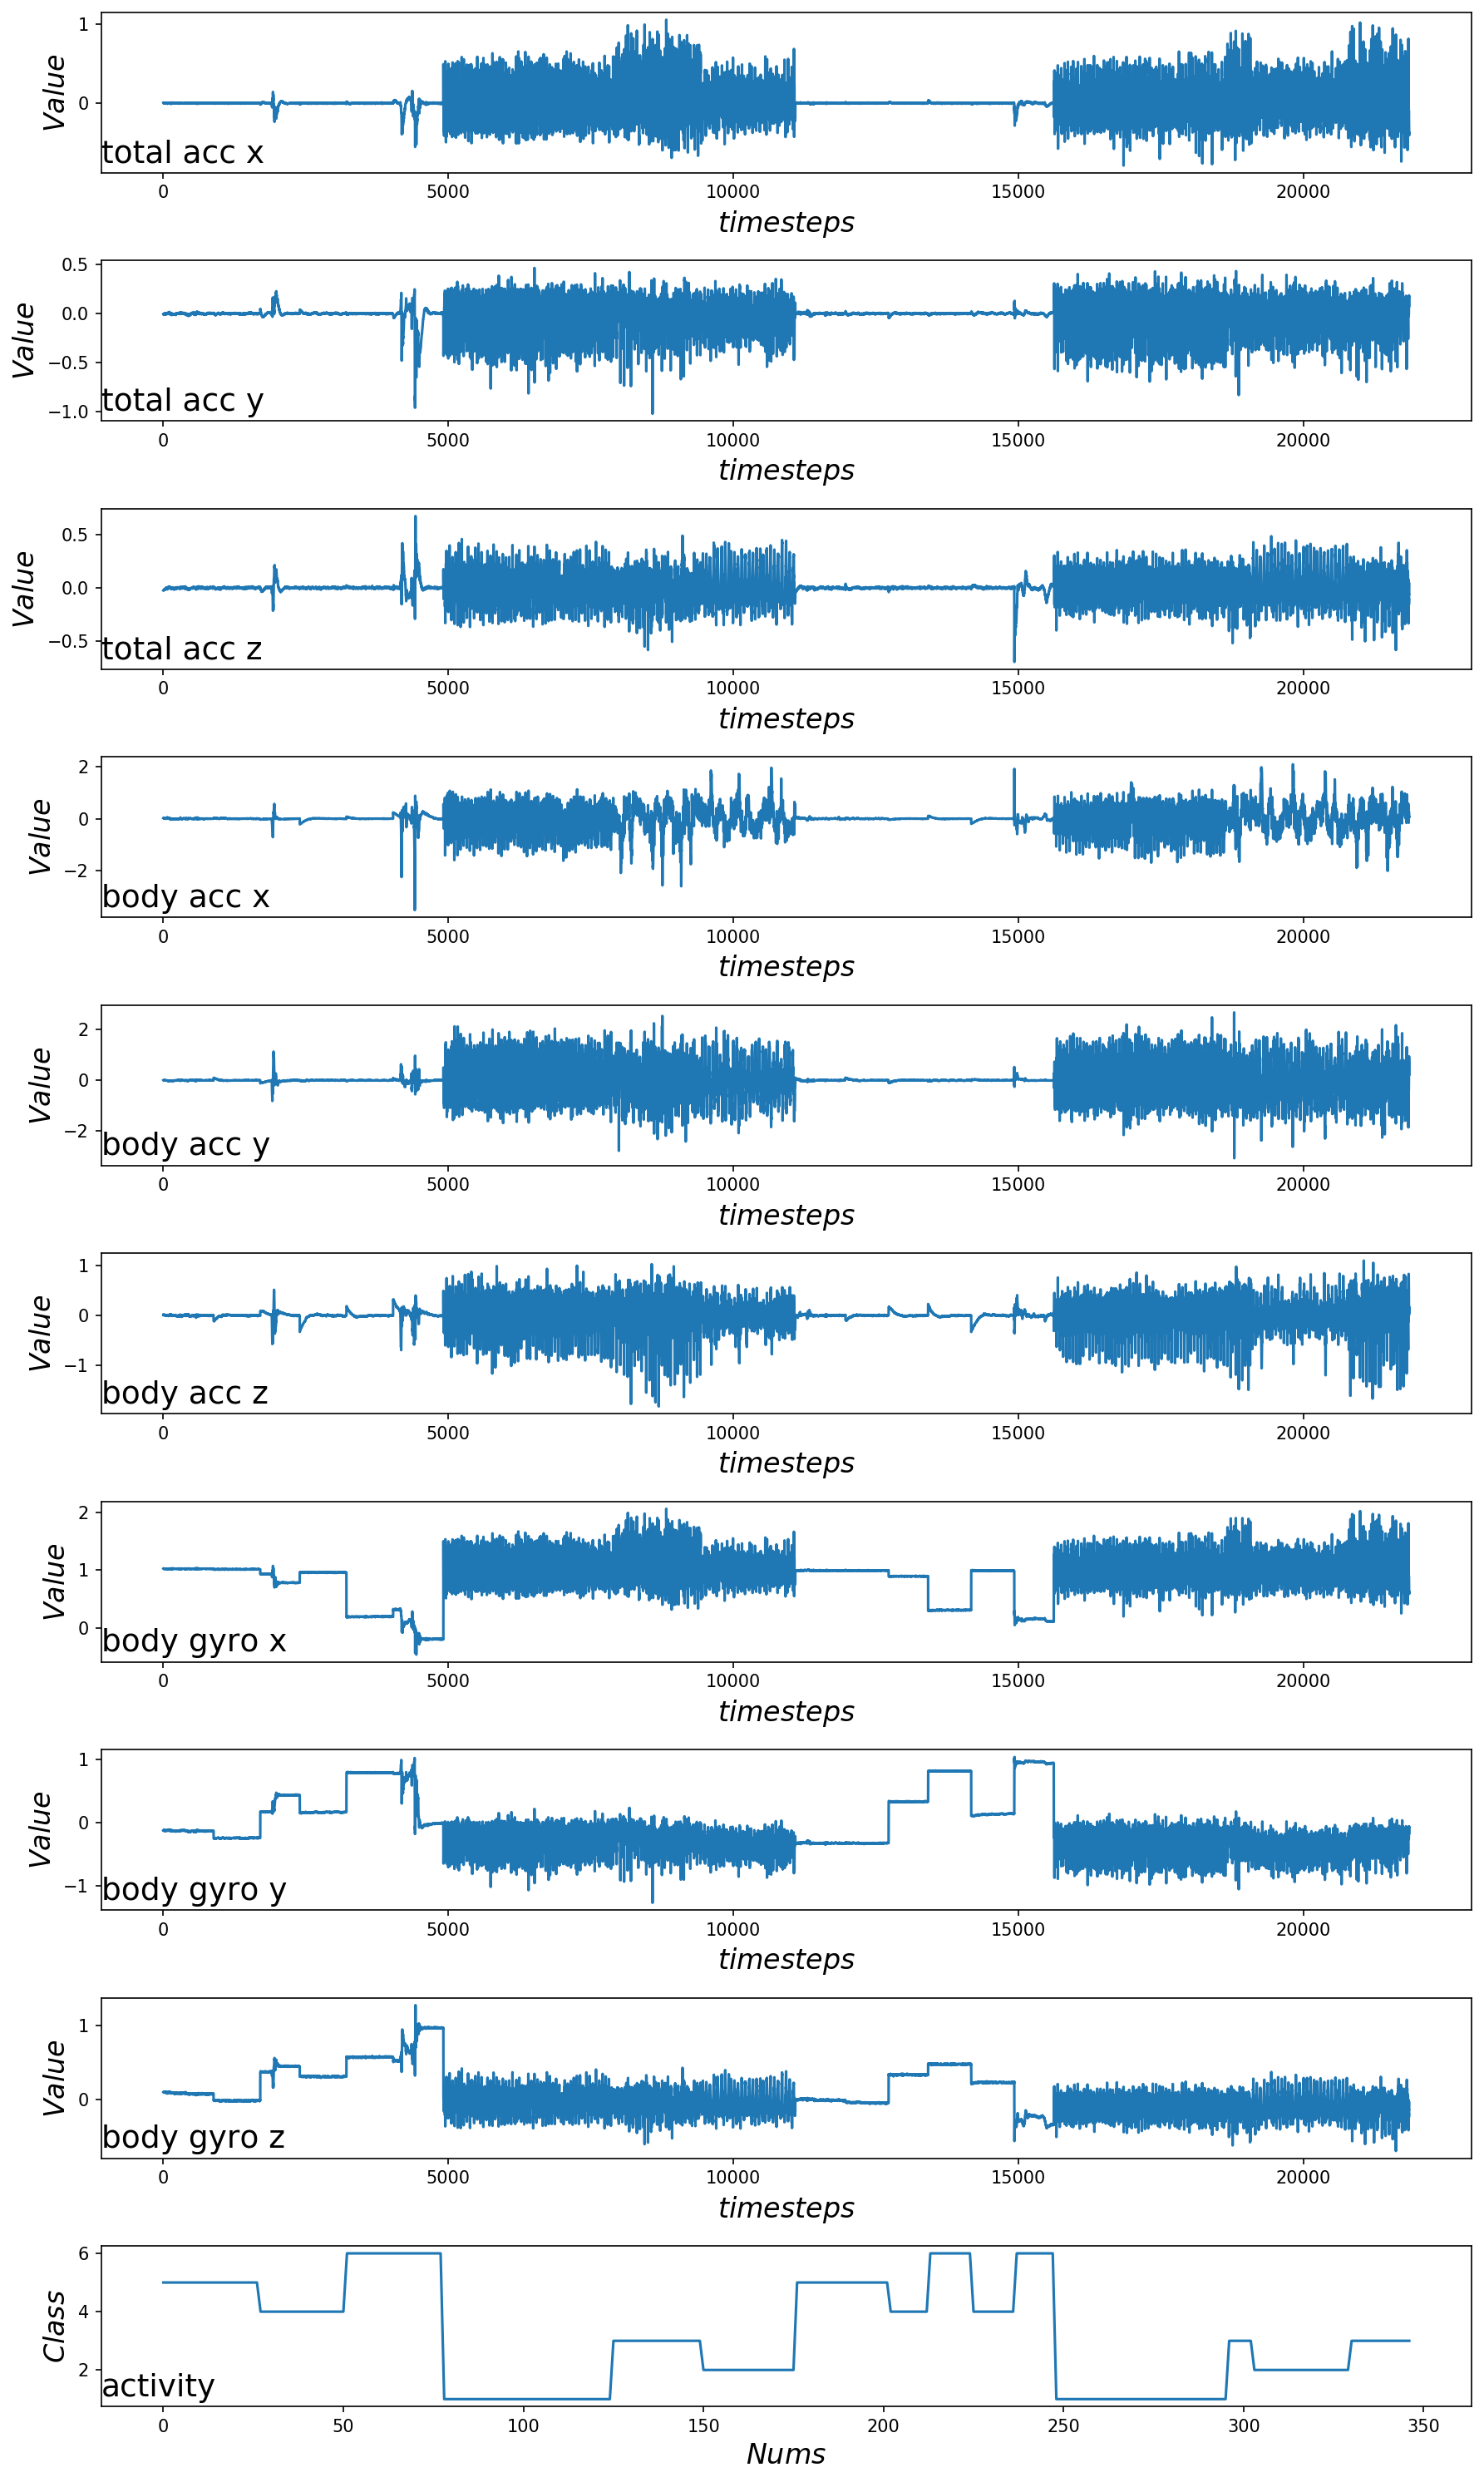

In [14]:
def plot_subject(X, y):
    '''
    该函数实现根据志愿者标号绘制其9轴传感器数据和活动变化图
    共十个子图
    '''
    plt.figure(figsize=(12,20), dpi=150)
    n, off = X.shape[2] + 1, 0 # X的第三个维度为特征数9（9轴传感器数据）

    name_list = ['total acc ', 'body acc ', 'body gyro ']
    axis_list = ['x', 'y', 'z']
    for name in name_list:
        for i, axis in enumerate(axis_list, start=0):
            plt.subplot(n, 1, off+1) # 创建n行1列的画布，在off+1位置绘图；
            # X[:,:,off] 三维数组切片中，off通过for循环实现递增，
            # 一次截取一个特征的所有数据（二维数组），输入到to_series函数进行处理，实现去除重叠部分。
            plt.plot(to_series(X[:,:,off]))
            plt.title(name + axis, y=0, loc='left', size=18)
            plt.ylabel(r'$Value$', size=16)
            plt.xlabel(r'$timesteps$', size=16)
            off += 1
    
    plt.subplot(n, 1, n)
    plt.plot(y)
    plt.title('activity', y=0, loc='left', size=18)
    plt.ylabel(r'$Class$', size=16)
    plt.xlabel(r'$Nums$', size=16)
    plt.tight_layout()
    plt.show()
    
plot_subject(train_subX, train_suby)

train_subX.shape:(316, 128, 9)
train_suby.shape:(316, 1)


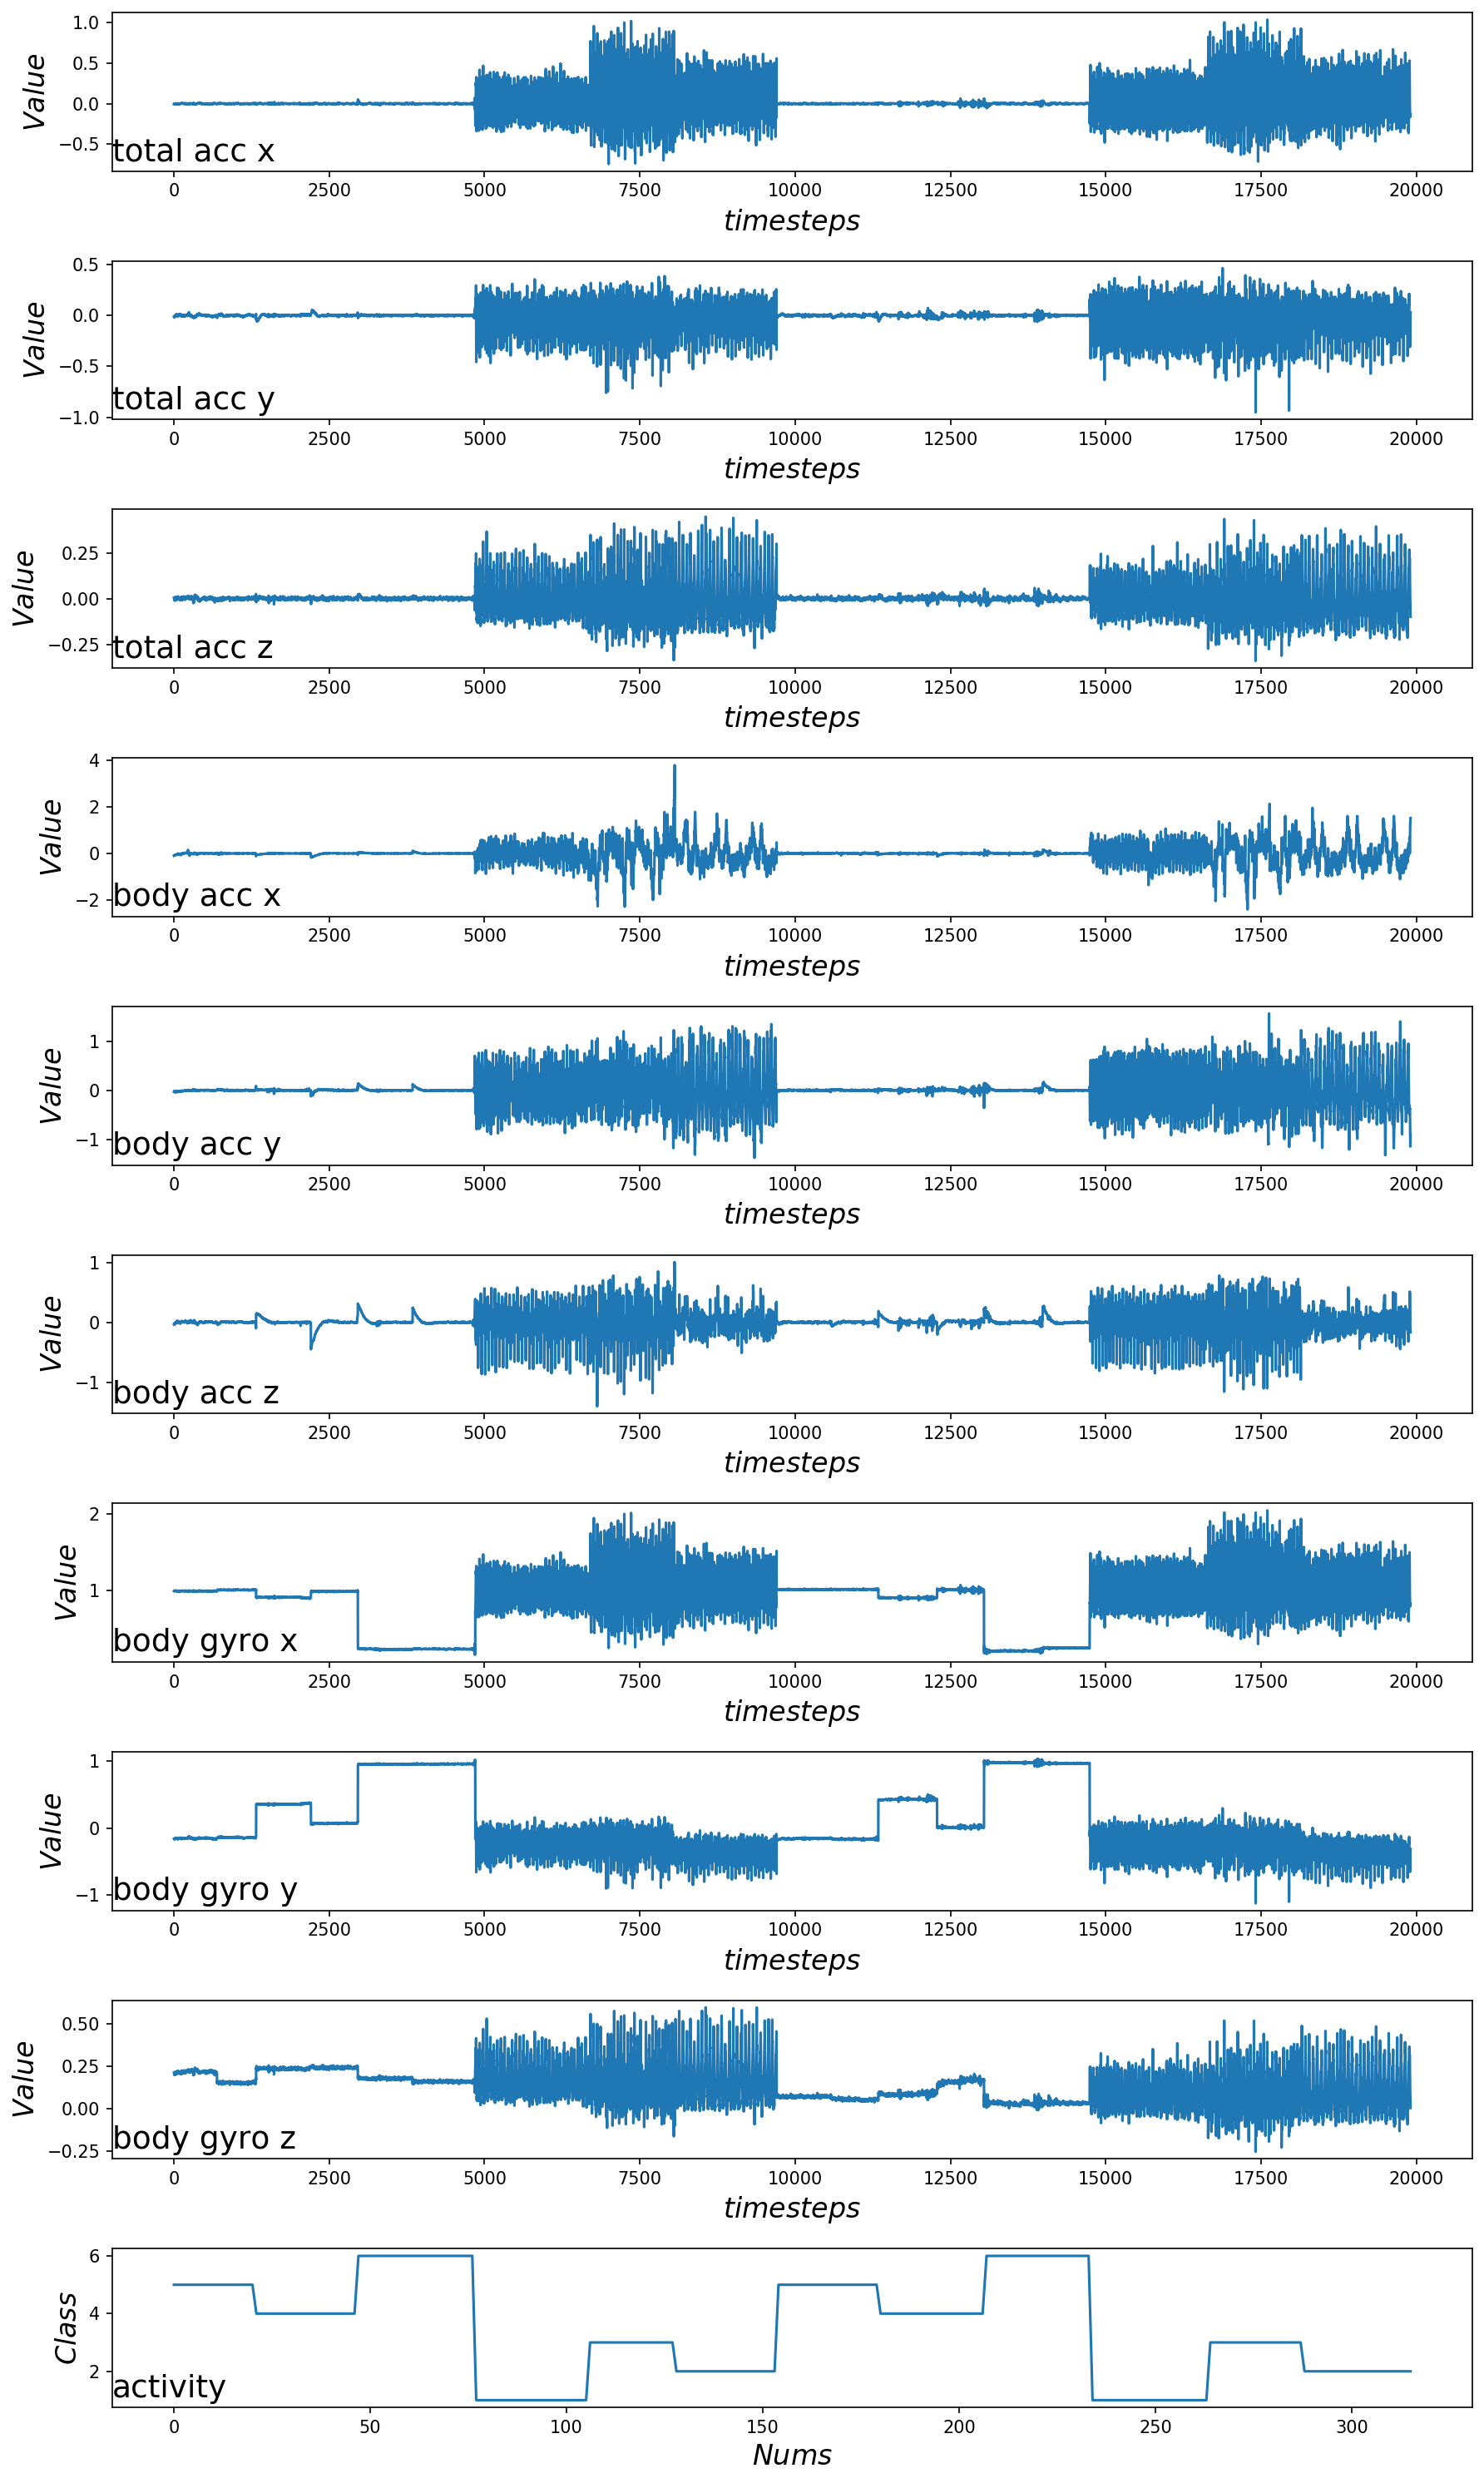

In [17]:
# 查看志愿者编号为11的数据情况
train_sub_id = train_subjects[6] # 列表中的第7位志愿者编号为11
train_subX, train_suby = data_for_subject(trainX, trainy, train_sub_map, train_sub_id)
print('train_subX.shape:{}\ntrain_suby.shape:{}'.format(train_subX.shape, train_suby.shape))
plot_subject(train_subX, train_suby)

C:\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


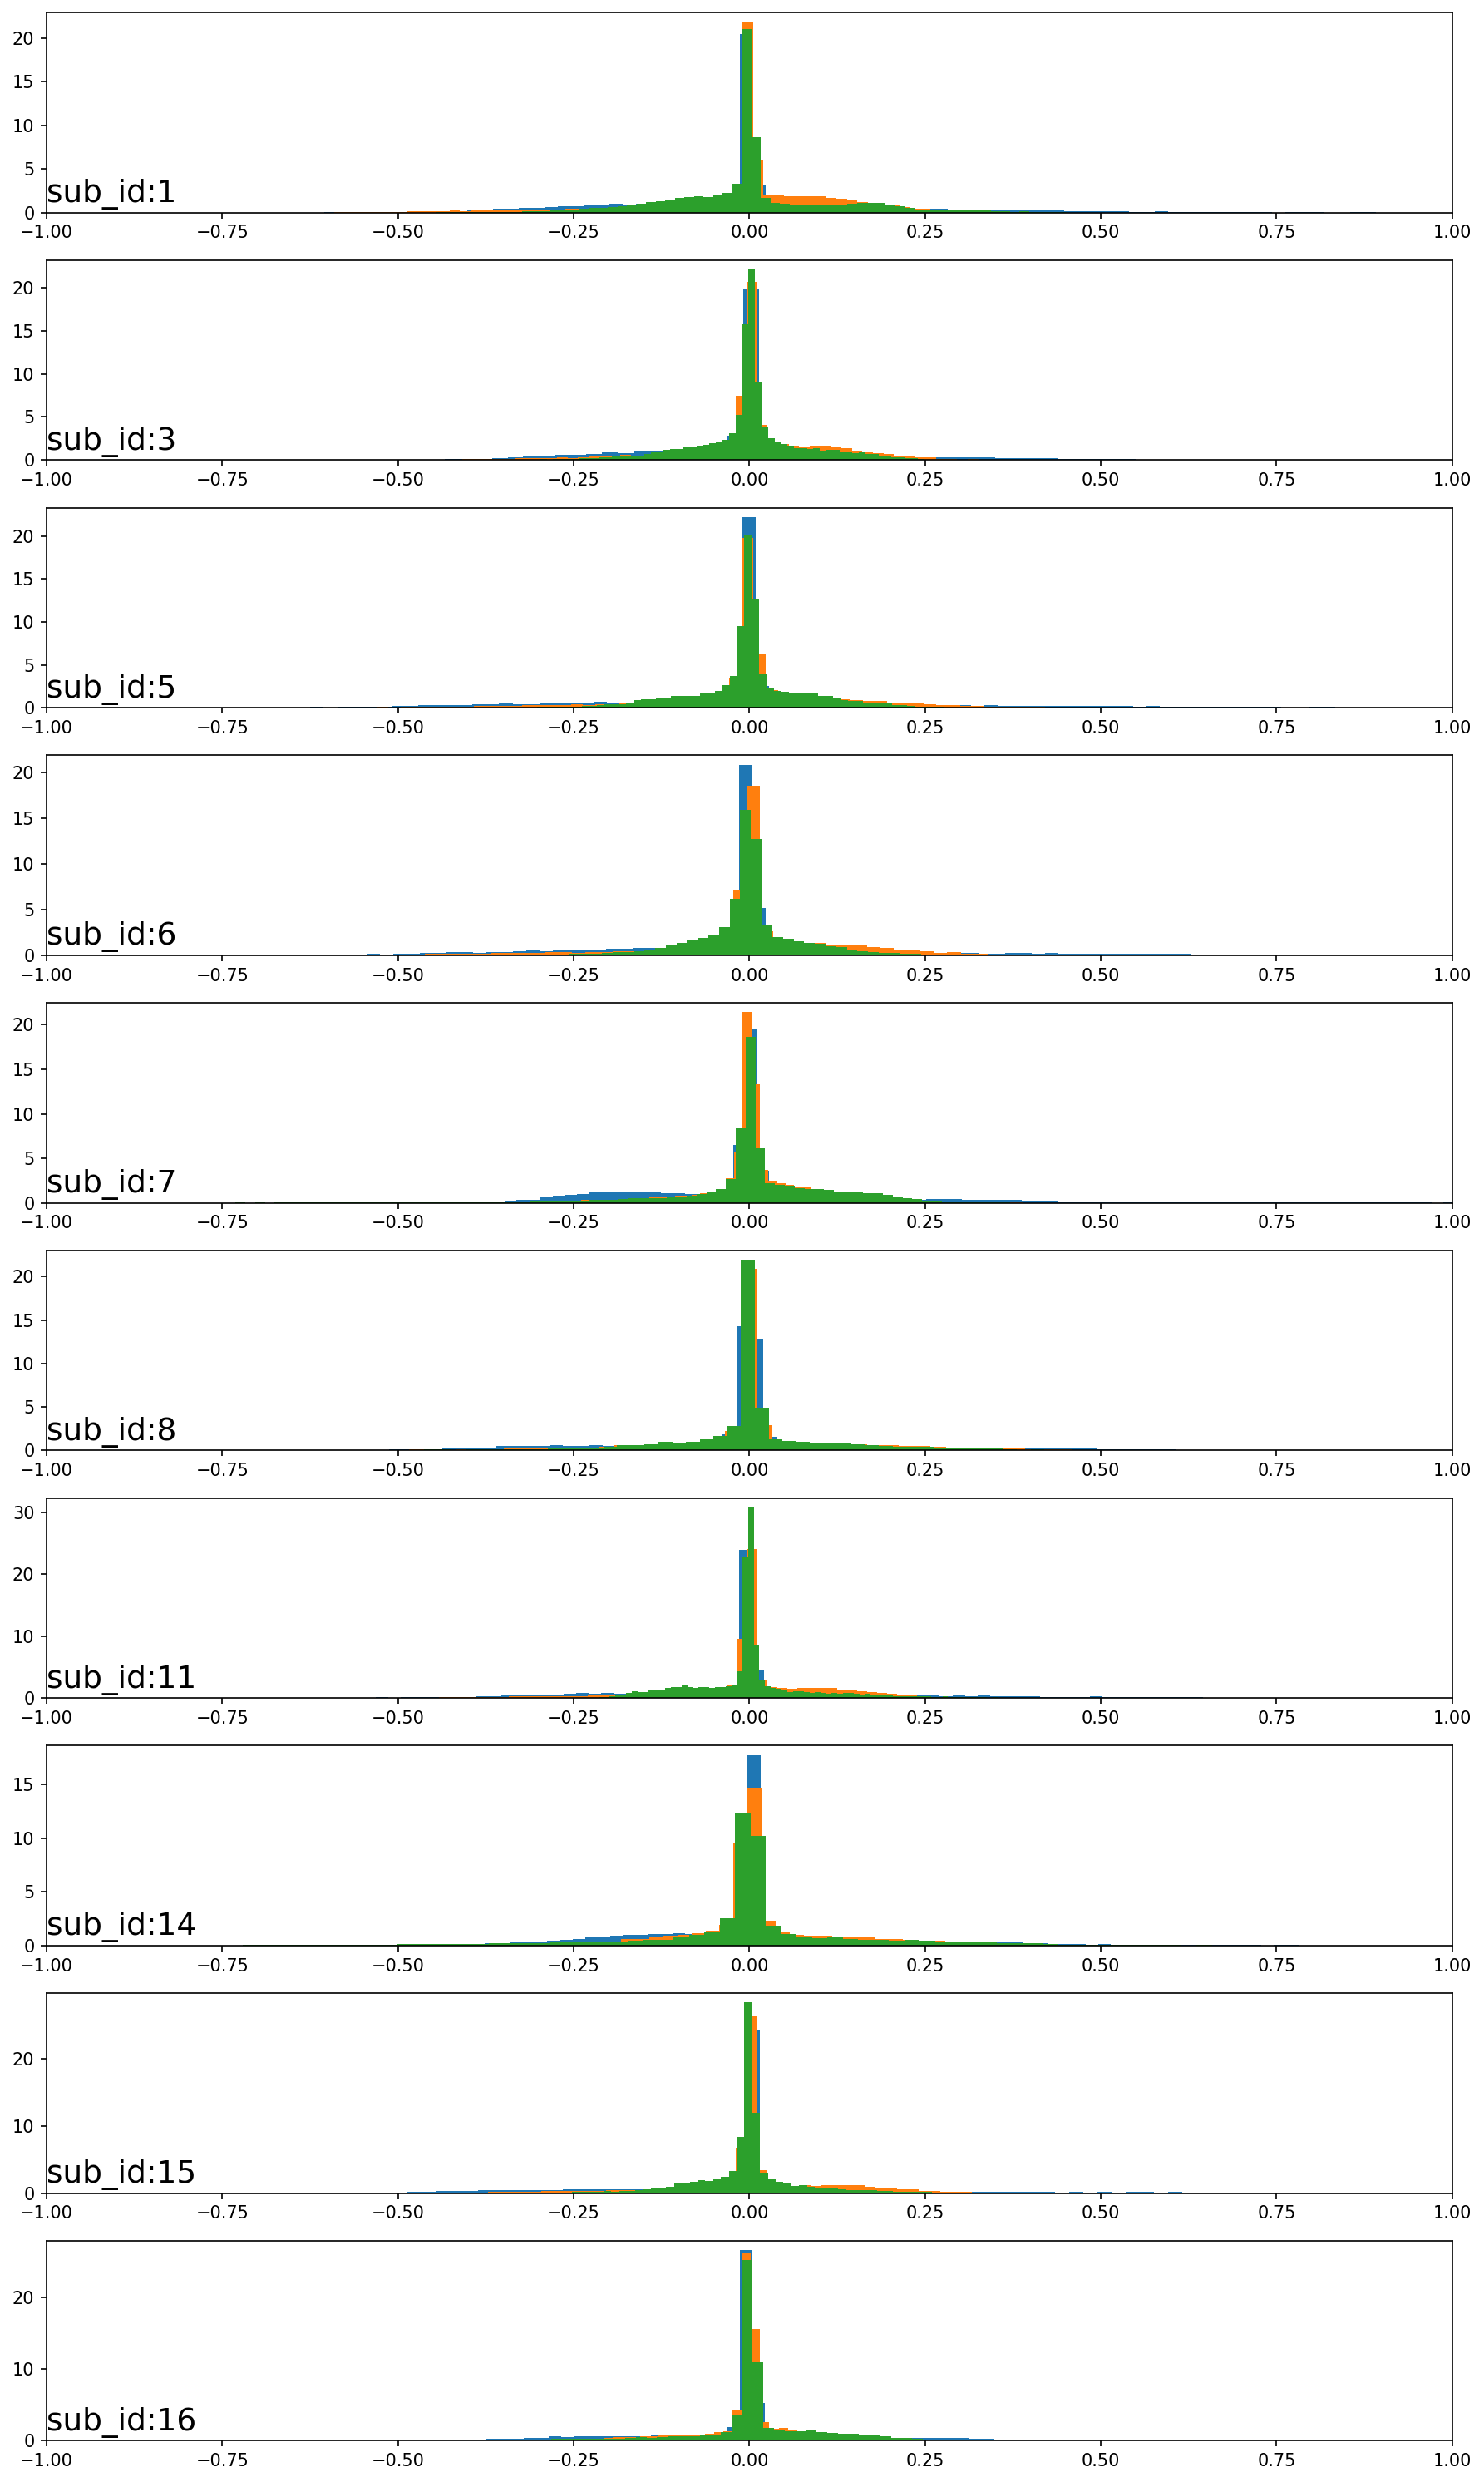

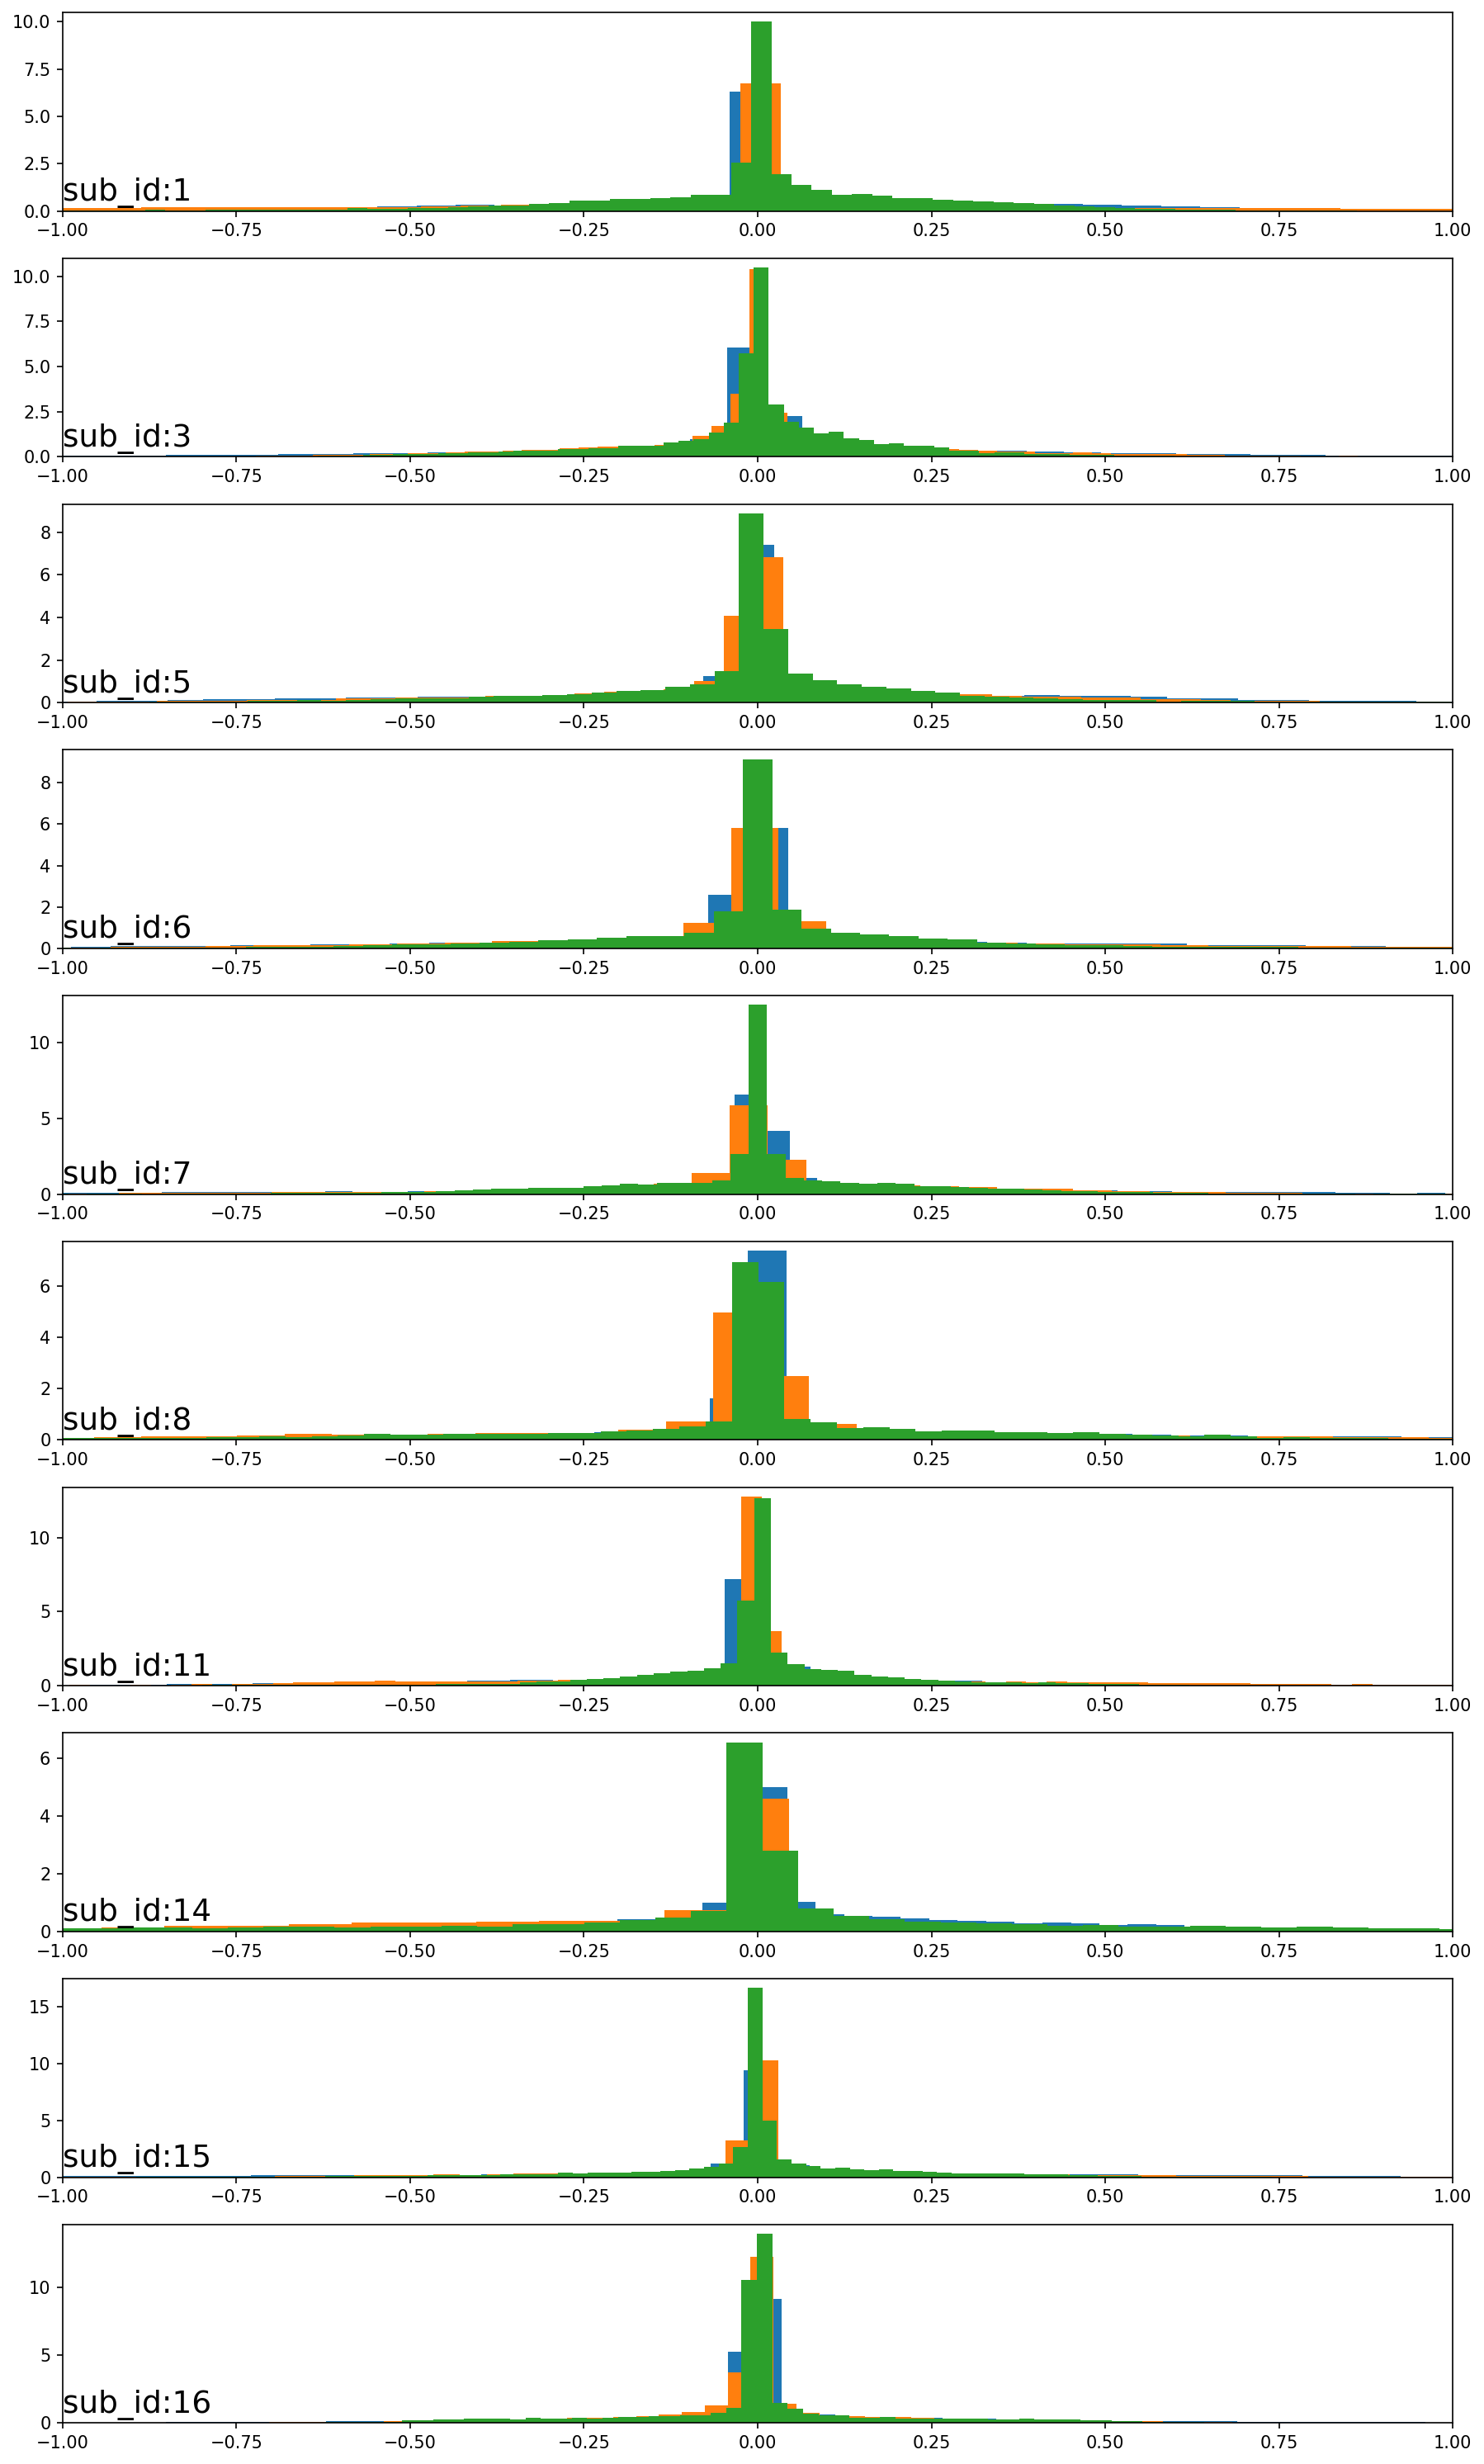

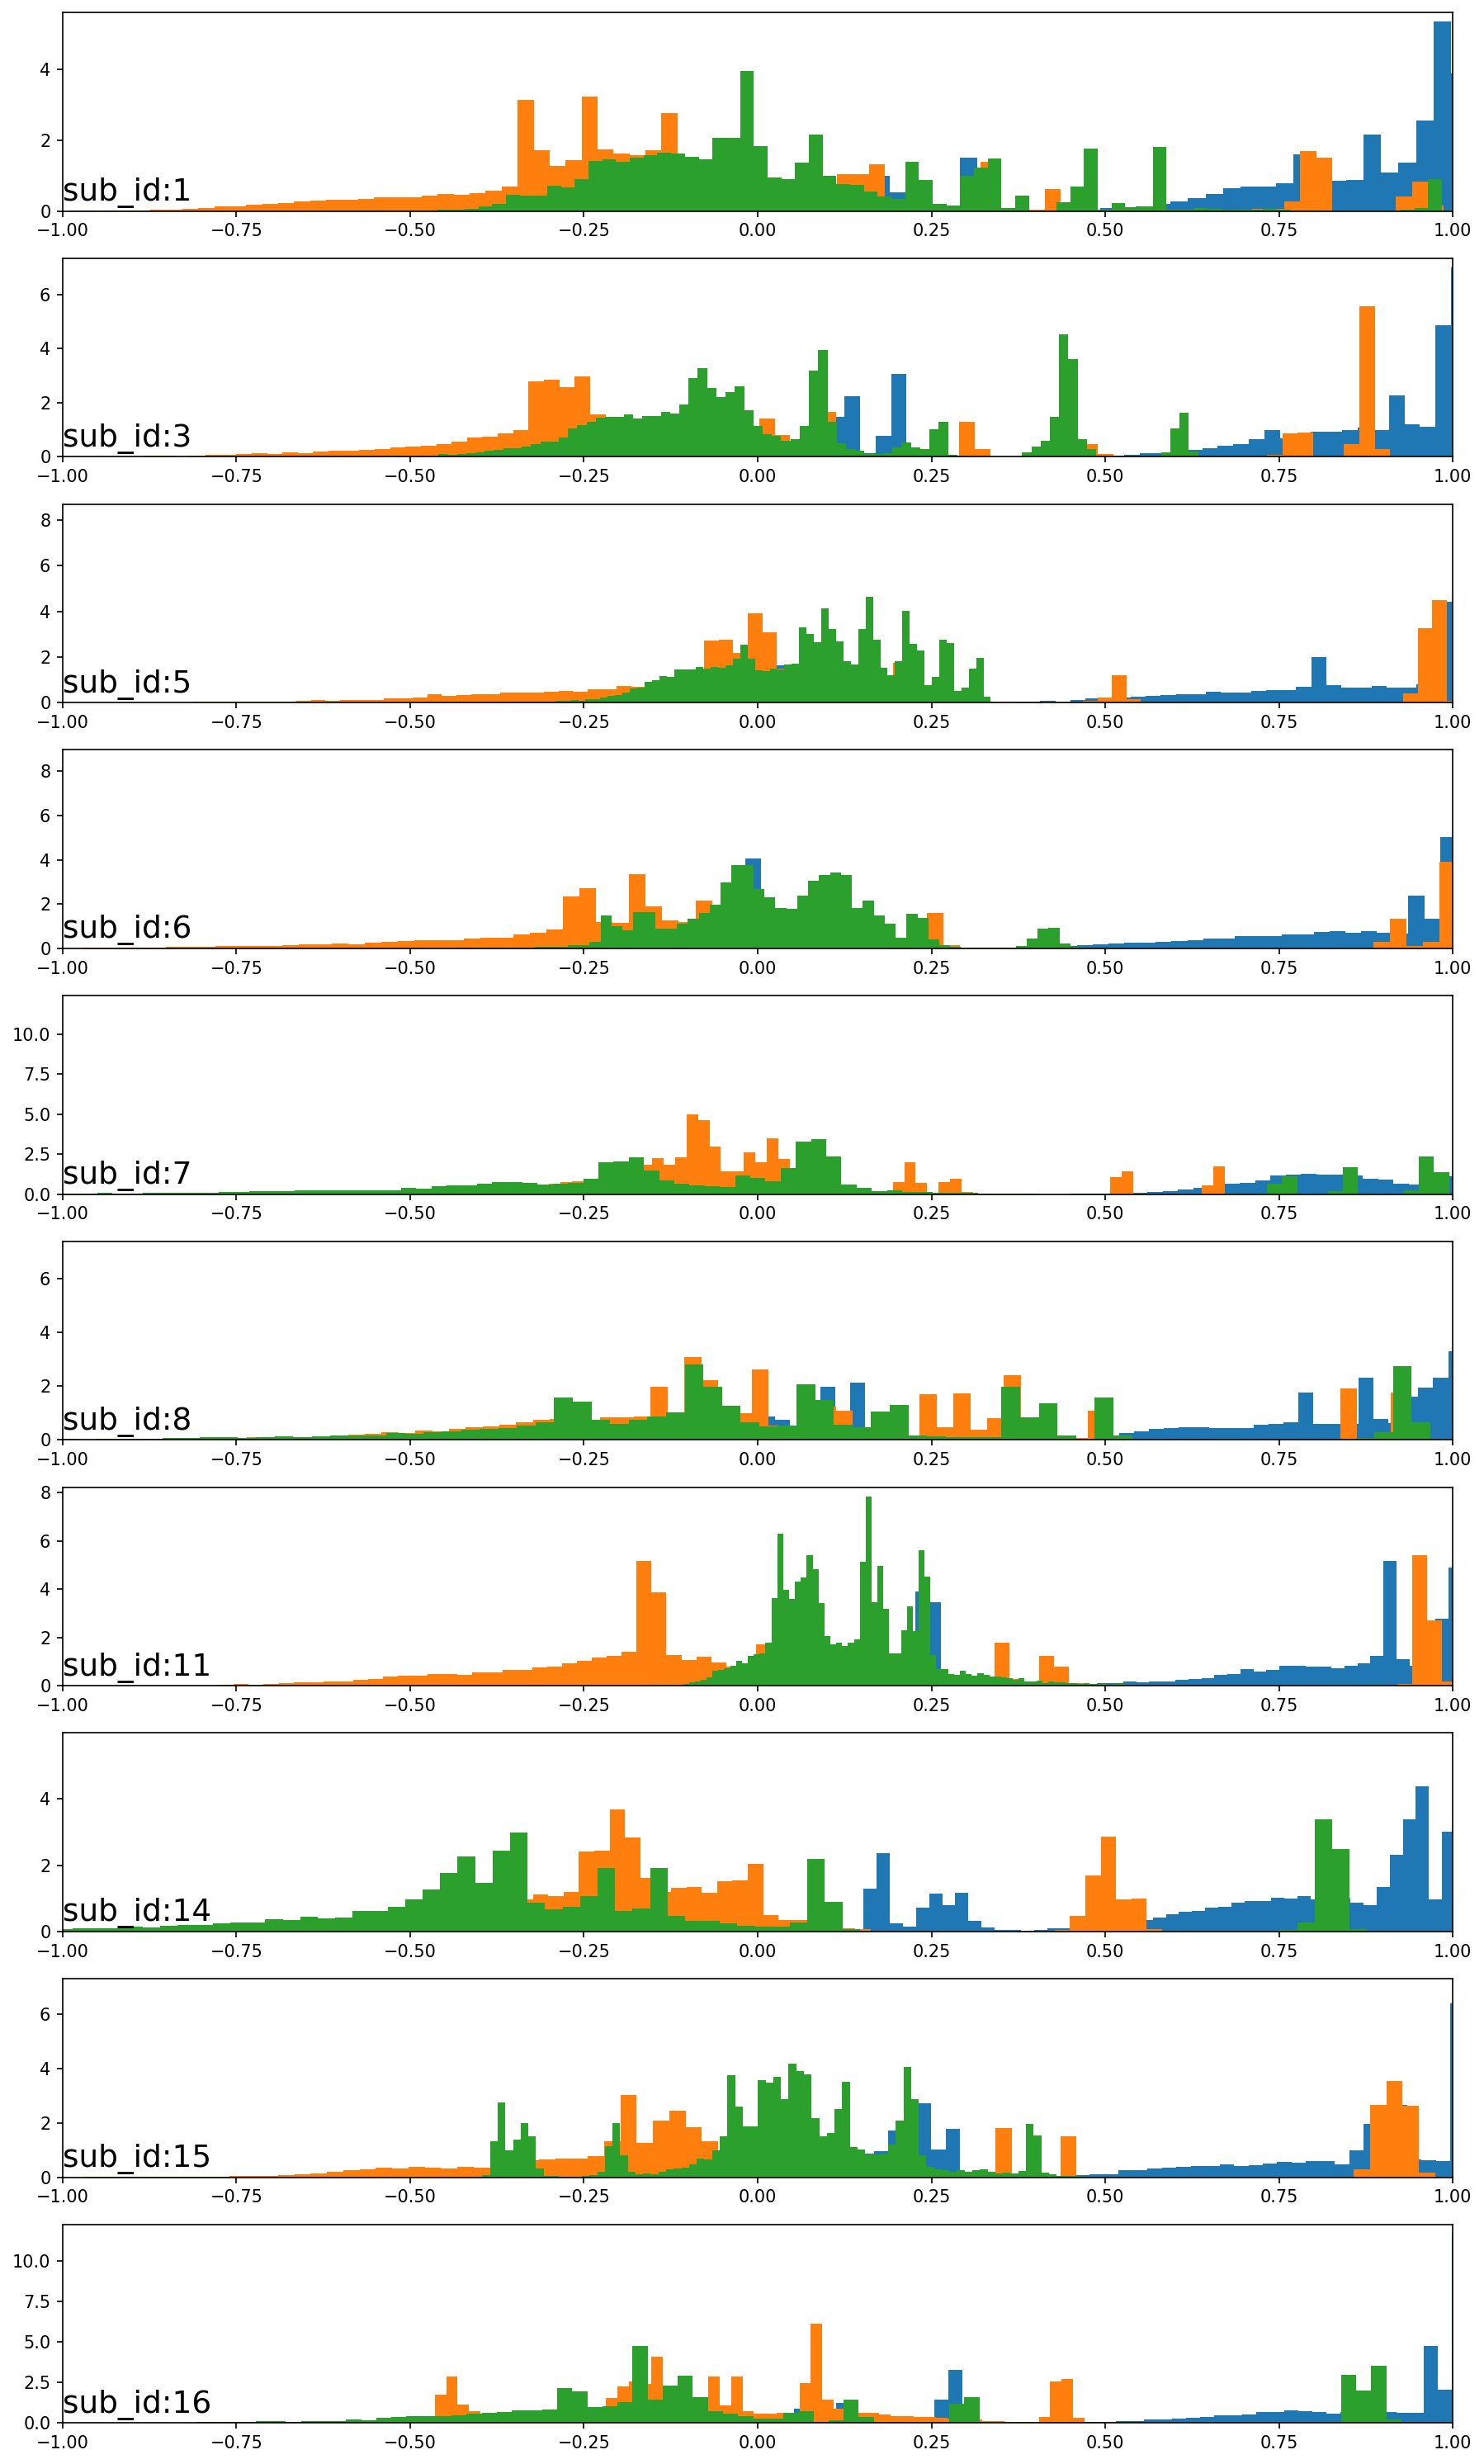

In [18]:
def plot_subject_histograms(X, y, sub_map, sensor_type_id, n_subs=10):
    '''
    该函数实现绘制指定数量志愿者的三轴传感数据直方图；
    sensor_type_id:指定绘制哪三轴，可选取值0,3,6；
    n_subs=10:表示默认绘制前十名志愿者的数据；
    '''
    plt.figure(figsize=(12,20), dpi=150)
    subject_ids = np.unique(sub_map[:, 0]) # 获取训练集或者测试集中所有志愿者的编号

    for i in range(n_subs):
        '''
        绘制n_subs个子图
        '''
        sub_id = subject_ids[i]
        subX, _ = data_for_subject(X, y, sub_map, sub_id) # 根据志愿者编号截取相应的数据

        for j in range(3):
            '''
            为一个子图绘制三轴传感数据的分布图
            '''
            ax = plt.subplot(n_subs, 1, i+1)
            ax.set_xlim(-1, 1)
            # 
            ax.hist(to_series(subX[:, :, sensor_type_id+j]), bins=100, density=True, histtype='bar', stacked=True)
        plt.title(f'sub_id:{sub_id}', y=0, loc='left', size=18)
    
    plt.tight_layout()         
    plt.show()
    
plot_subject_histograms(trainX, trainy, train_sub_map, sensor_type_id=0) #10位志愿者总的加速度数据分布图
plot_subject_histograms(trainX, trainy, train_sub_map, sensor_type_id=3) #...身体加速度
plot_subject_histograms(trainX, trainy, train_sub_map, sensor_type_id=6) #...重力加速度

In [21]:
# 将数据按活动类别分组
def data_by_activity(X, y, activities):
    return {a:X[y[:,0]==a, :, :] for a in activities}

[1 2 3 4 5 6]


C:\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


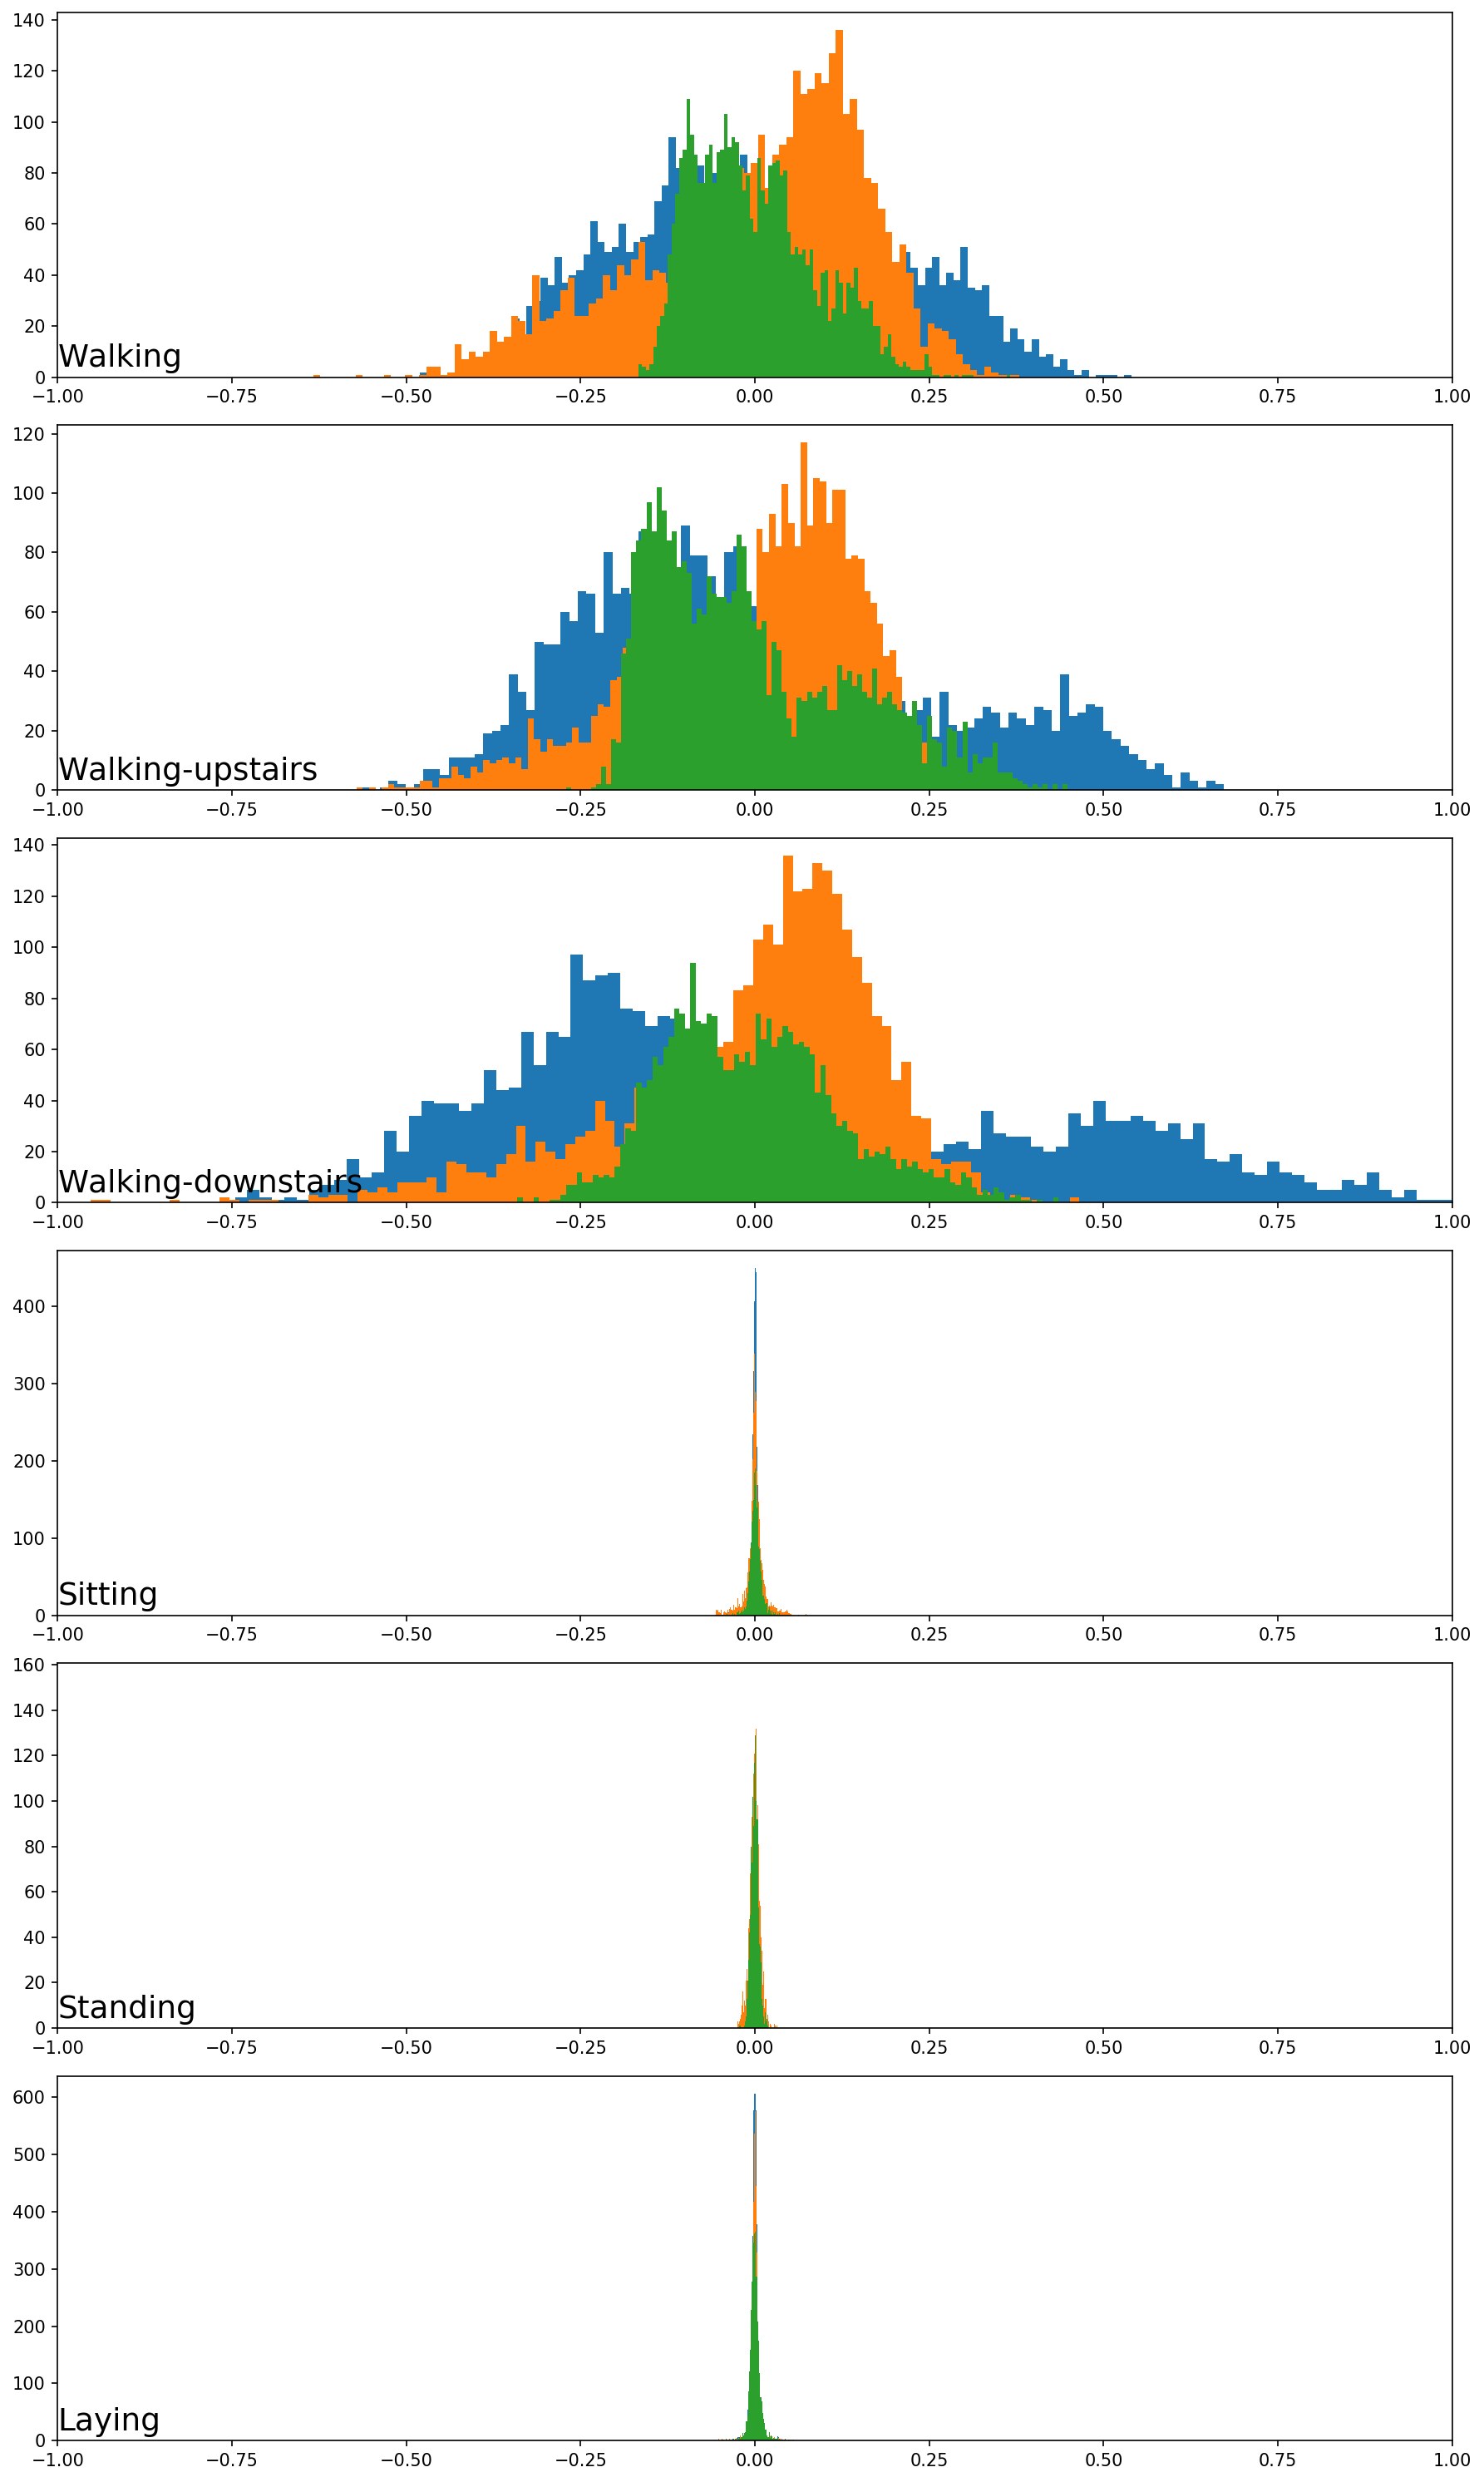

[1 2 3 4 5 6]


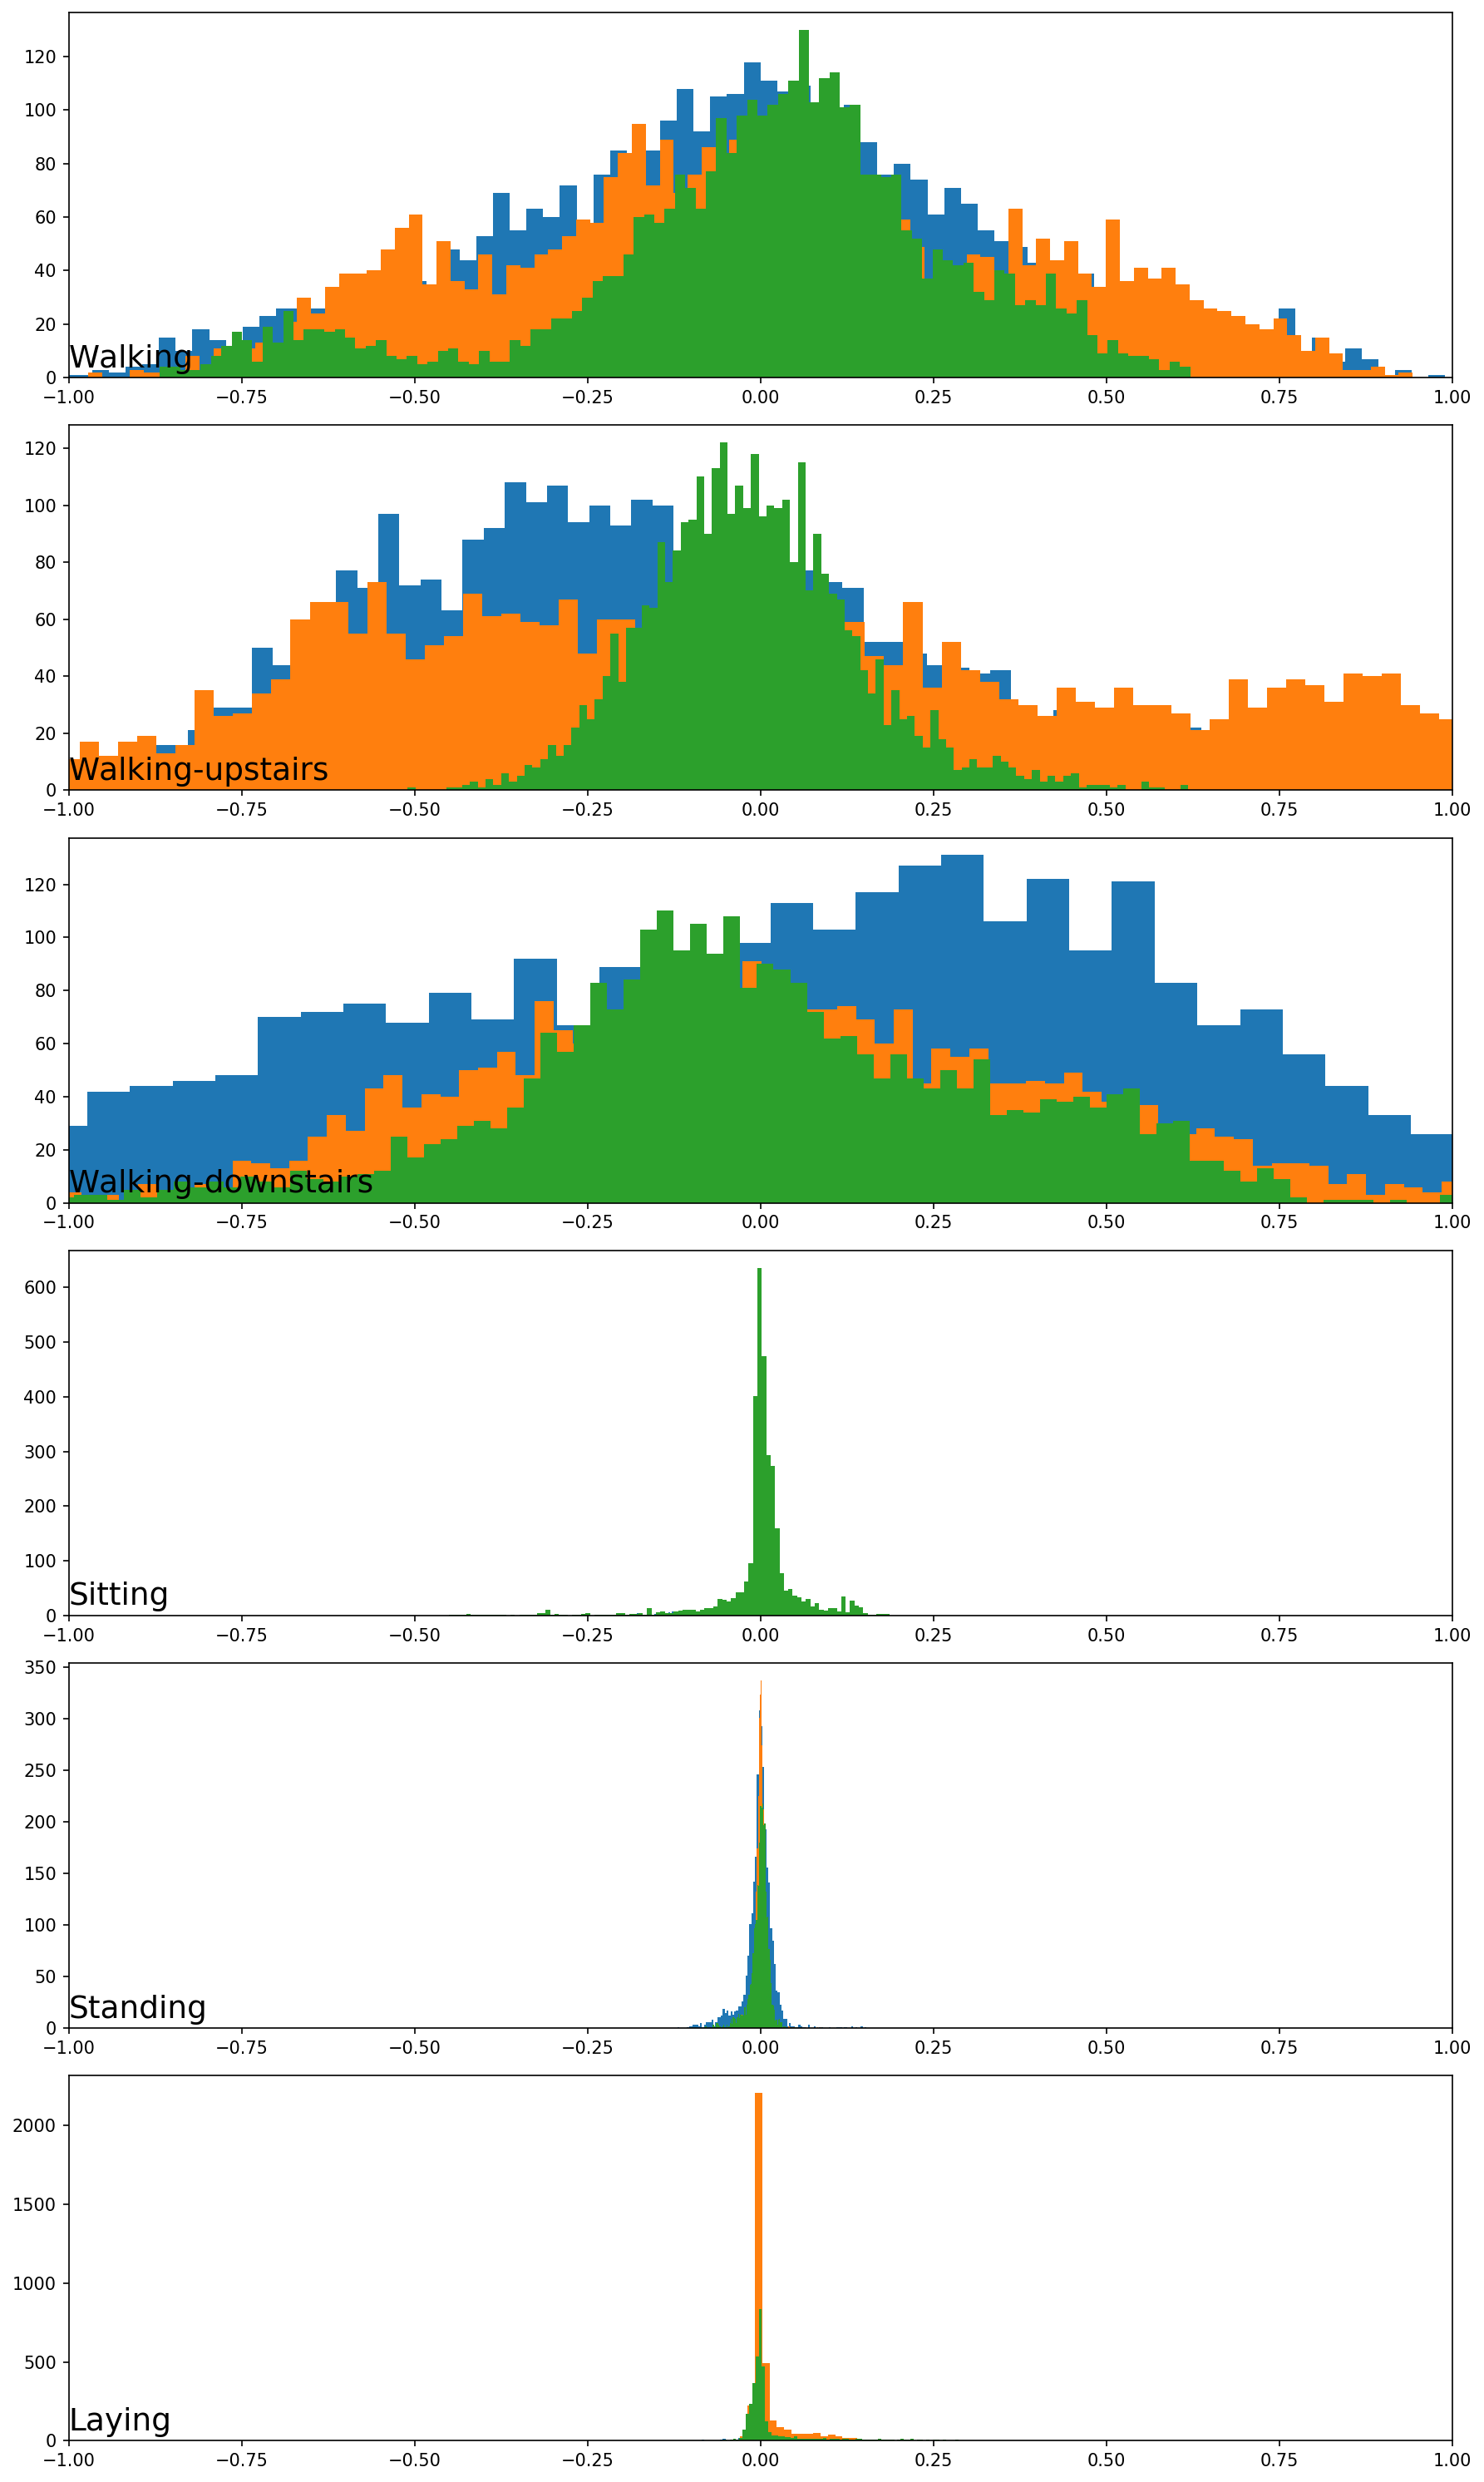

[1 2 3 4 5 6]


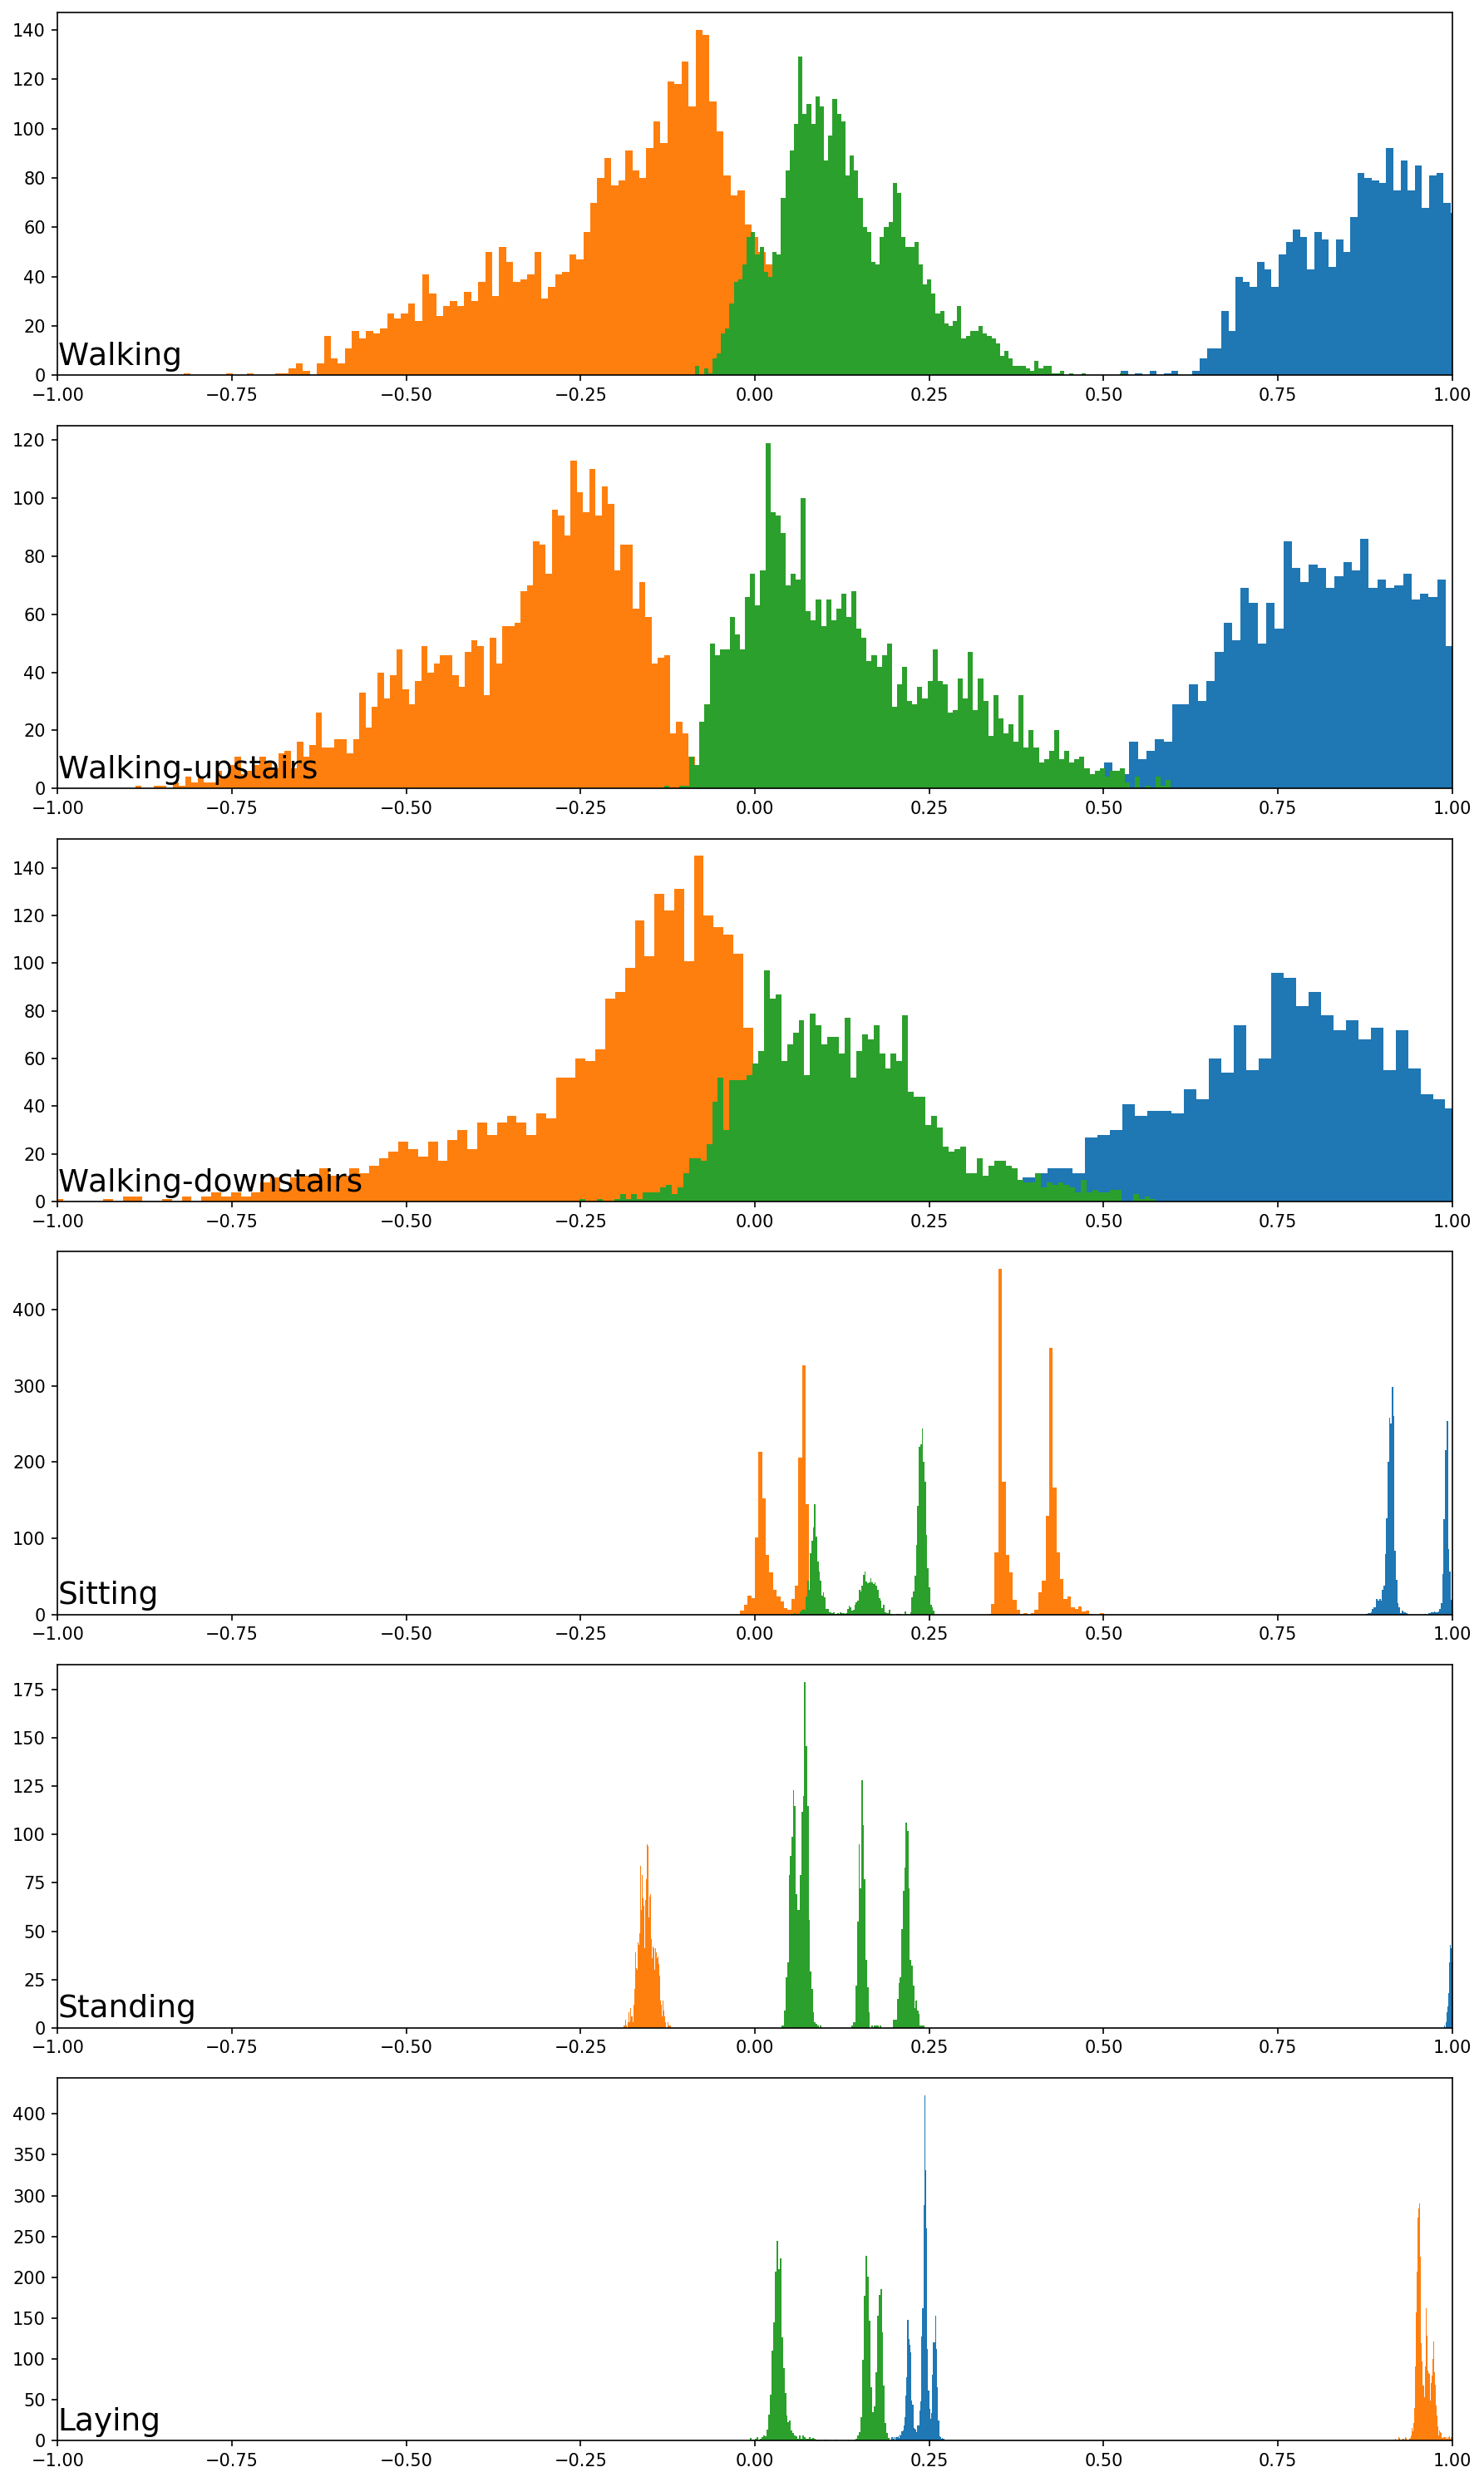

In [22]:
def plot_activity_histograms(X, y, sensor_type_id):
    activity_ids = np.unique(y[:, 0]) # 获取训练集或测试集标签中的类别编号（1-6）
    grouped = data_by_activity(X, y, activity_ids)
    plt.figure(figsize=(12,20), dpi=150)
    
    activity_list = ['Walking','Walking-upstairs','Walking-downstairs','Sitting','Standing','Laying']
    print(activity_ids)
    for i, activity in enumerate(activity_list, start=0):
        act_id = activity_ids[i]
        
        for j in range(3): # 总的加速度
            ax = plt.subplot(len(activity_ids), 1, i+1)
            ax.set_xlim(-1,1)
            plt.hist(to_series(grouped[act_id][:, :, sensor_type_id + j]), bins=100)
            
        plt.title(activity, y=0, loc='left', size=18)
    plt.tight_layout()
    plt.show()

plot_activity_histograms(train_subX, train_suby, sensor_type_id=0) # 身体加速度
plot_activity_histograms(train_subX, train_suby, sensor_type_id=3) # 身体角速度
plot_activity_histograms(train_subX, train_suby, sensor_type_id=6) # 重力加速度

In [32]:
import random
def random_color(nums):
    '''
    该函数实现生成指定数量的随机颜色列表
    '''
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ''
    color_list = []
    for i in range(nums):
        for i in range(6):
            color += colorArr[random.randint(0,14)]
        color_list.append('#'+color)
        color = ''
    return color_list

In [27]:
def get_act_dura_by_sub(X, y, sub_map):
    '''
    该函数实现找到训练集或者测试集中各类活动的数量
    '''
    subject_ids = np.unique(sub_map[:,0])
    activity_ids = np.unique(y[:,0])

    activity_windows = {a:list() for a in activity_ids} # 为每个活动建一个列表
    
    plt.figure(figsize=(12,8), dpi=150)

    for sub_id in subject_ids:
        _, subj_y = data_for_subject(X, y, sub_map, sub_id)

        for a in activity_ids:
            activity_windows[a].append(len(subj_y[subj_y[:,0]==a]))
            
    durations = [activity_windows[a] for a in activity_ids] # 将持续时间整理到列表列表中
    
    return durations

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

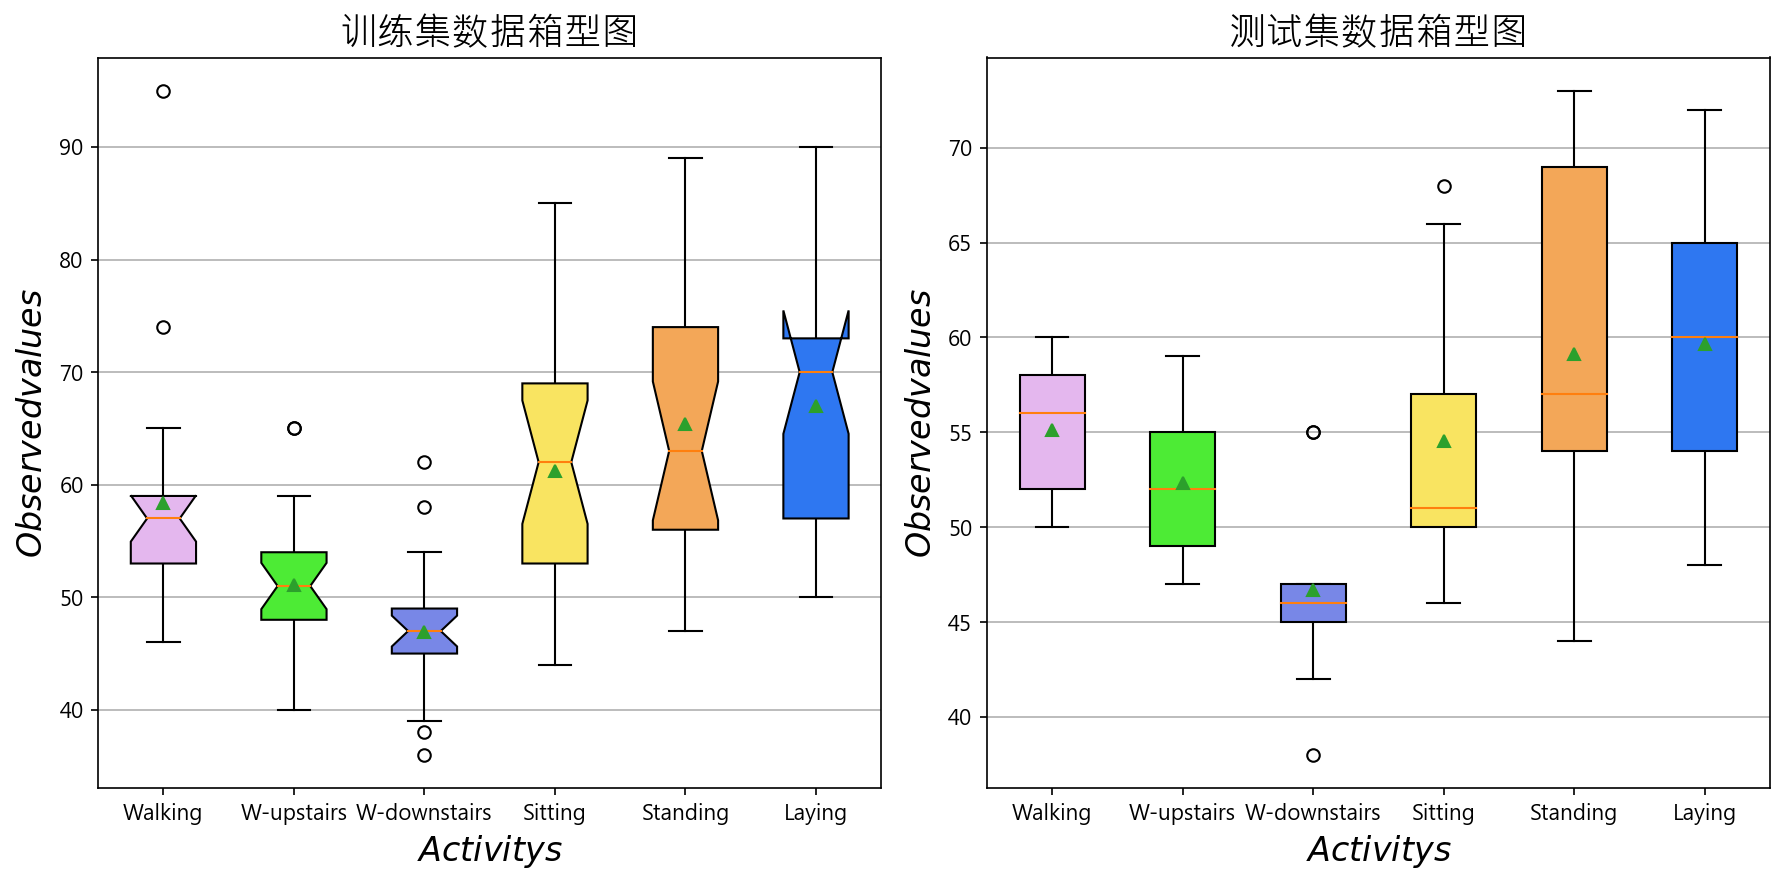

In [40]:
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

def plot_box_act(train_sub_fp, test_sub_fp, labels, 
                 show_colors=True, show_hori_lines=True):
    
    sub_map_train = load_file(train_sub_fp)
    train_dura = get_act_dura_by_sub(trainX, trainy, sub_map_train)
    
    sub_map_test = load_file(test_sub_fp)
    test_dura = get_act_dura_by_sub(testX, testy, sub_map_test)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=150)
        
    # vert=True：水平; patch_artist=True：填充颜色；showmeans=True：显示均值；notch=True：以凹口形式绘制箱形图；sym= ：异常点的形状；
    bplot1 = ax1.boxplot(train_dura, vert=True,  patch_artist=True, showmeans=True, notch=True, sym='o', labels=labels) 
    ax1.set_title('训练集数据箱型图', size=18)

    bplot2 = ax2.boxplot(test_dura, vert=True,  patch_artist=True, showmeans=True, labels=labels)
    ax2.set_title('测试集数据箱型图', size=18)
    
    # 填充颜色
    if show_colors == True:
        colors = random_color(len(labels))
        for bplot in (bplot1, bplot2):
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)

    # 增加水平线
    if show_hori_lines == True:
        for ax in [ax1, ax2]:
            ax.yaxis.grid(True)
            ax.set_xlabel('$Activitys$', size=16)
            ax.set_ylabel('$Observed values$', size=16)
    
    plt.tight_layout()
    plt.show()
            
train_sub_fp = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/subject_train.txt'
test_sub_fp = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/subject_test.txt'
labels = ['Walking','W-upstairs','W-downstairs','Sitting','Standing','Laying']
plot_box_act(train_sub_fp, test_sub_fp, labels, show_colors=True, show_hori_lines=True)